In [29]:
!pip install -Uqq fastai ipywidgets duckduckgo_search

# Working with Images

PIL (Python Imaging Library) is a library for opening, manipulating, and saving many different image file formats. It provides a wide range of image processing capabilities and is widely used for tasks such as image enhancement, filtering, composition, and more.

PIL is no longer maintained, so instead, we usually end up using a fork of it called Pillow. The fork provides a backwards compatible API.

Fastai provides helper functions that makes working with images easier. It can help download and manipulate images in batch.

## Getting Started

To use PIL, start by importing the `Image` module from the `PIL` package.

In [30]:
from PIL import Image

Alternatively, you can use the core vision library from [fast.ai](https://docs.fast.ai/vision.core.html). This will bring in PIL and some useful extensions to it, as well as some [external data helpers](https://docs.fast.ai/data.external.html) and [fast.ai helpers for torch](https://docs.fast.ai/torch_core.html). This cheatsheat will use PIL in the context of fast.ai, so we'll use that.

In [31]:
from fastai.vision.core import *

## Loading Images

### Load a file

To open an image directly with PIL, you can use `Image.open()`

In [32]:
image = Image.open("images/bird.jpg")

In your notebook, you can see the image:

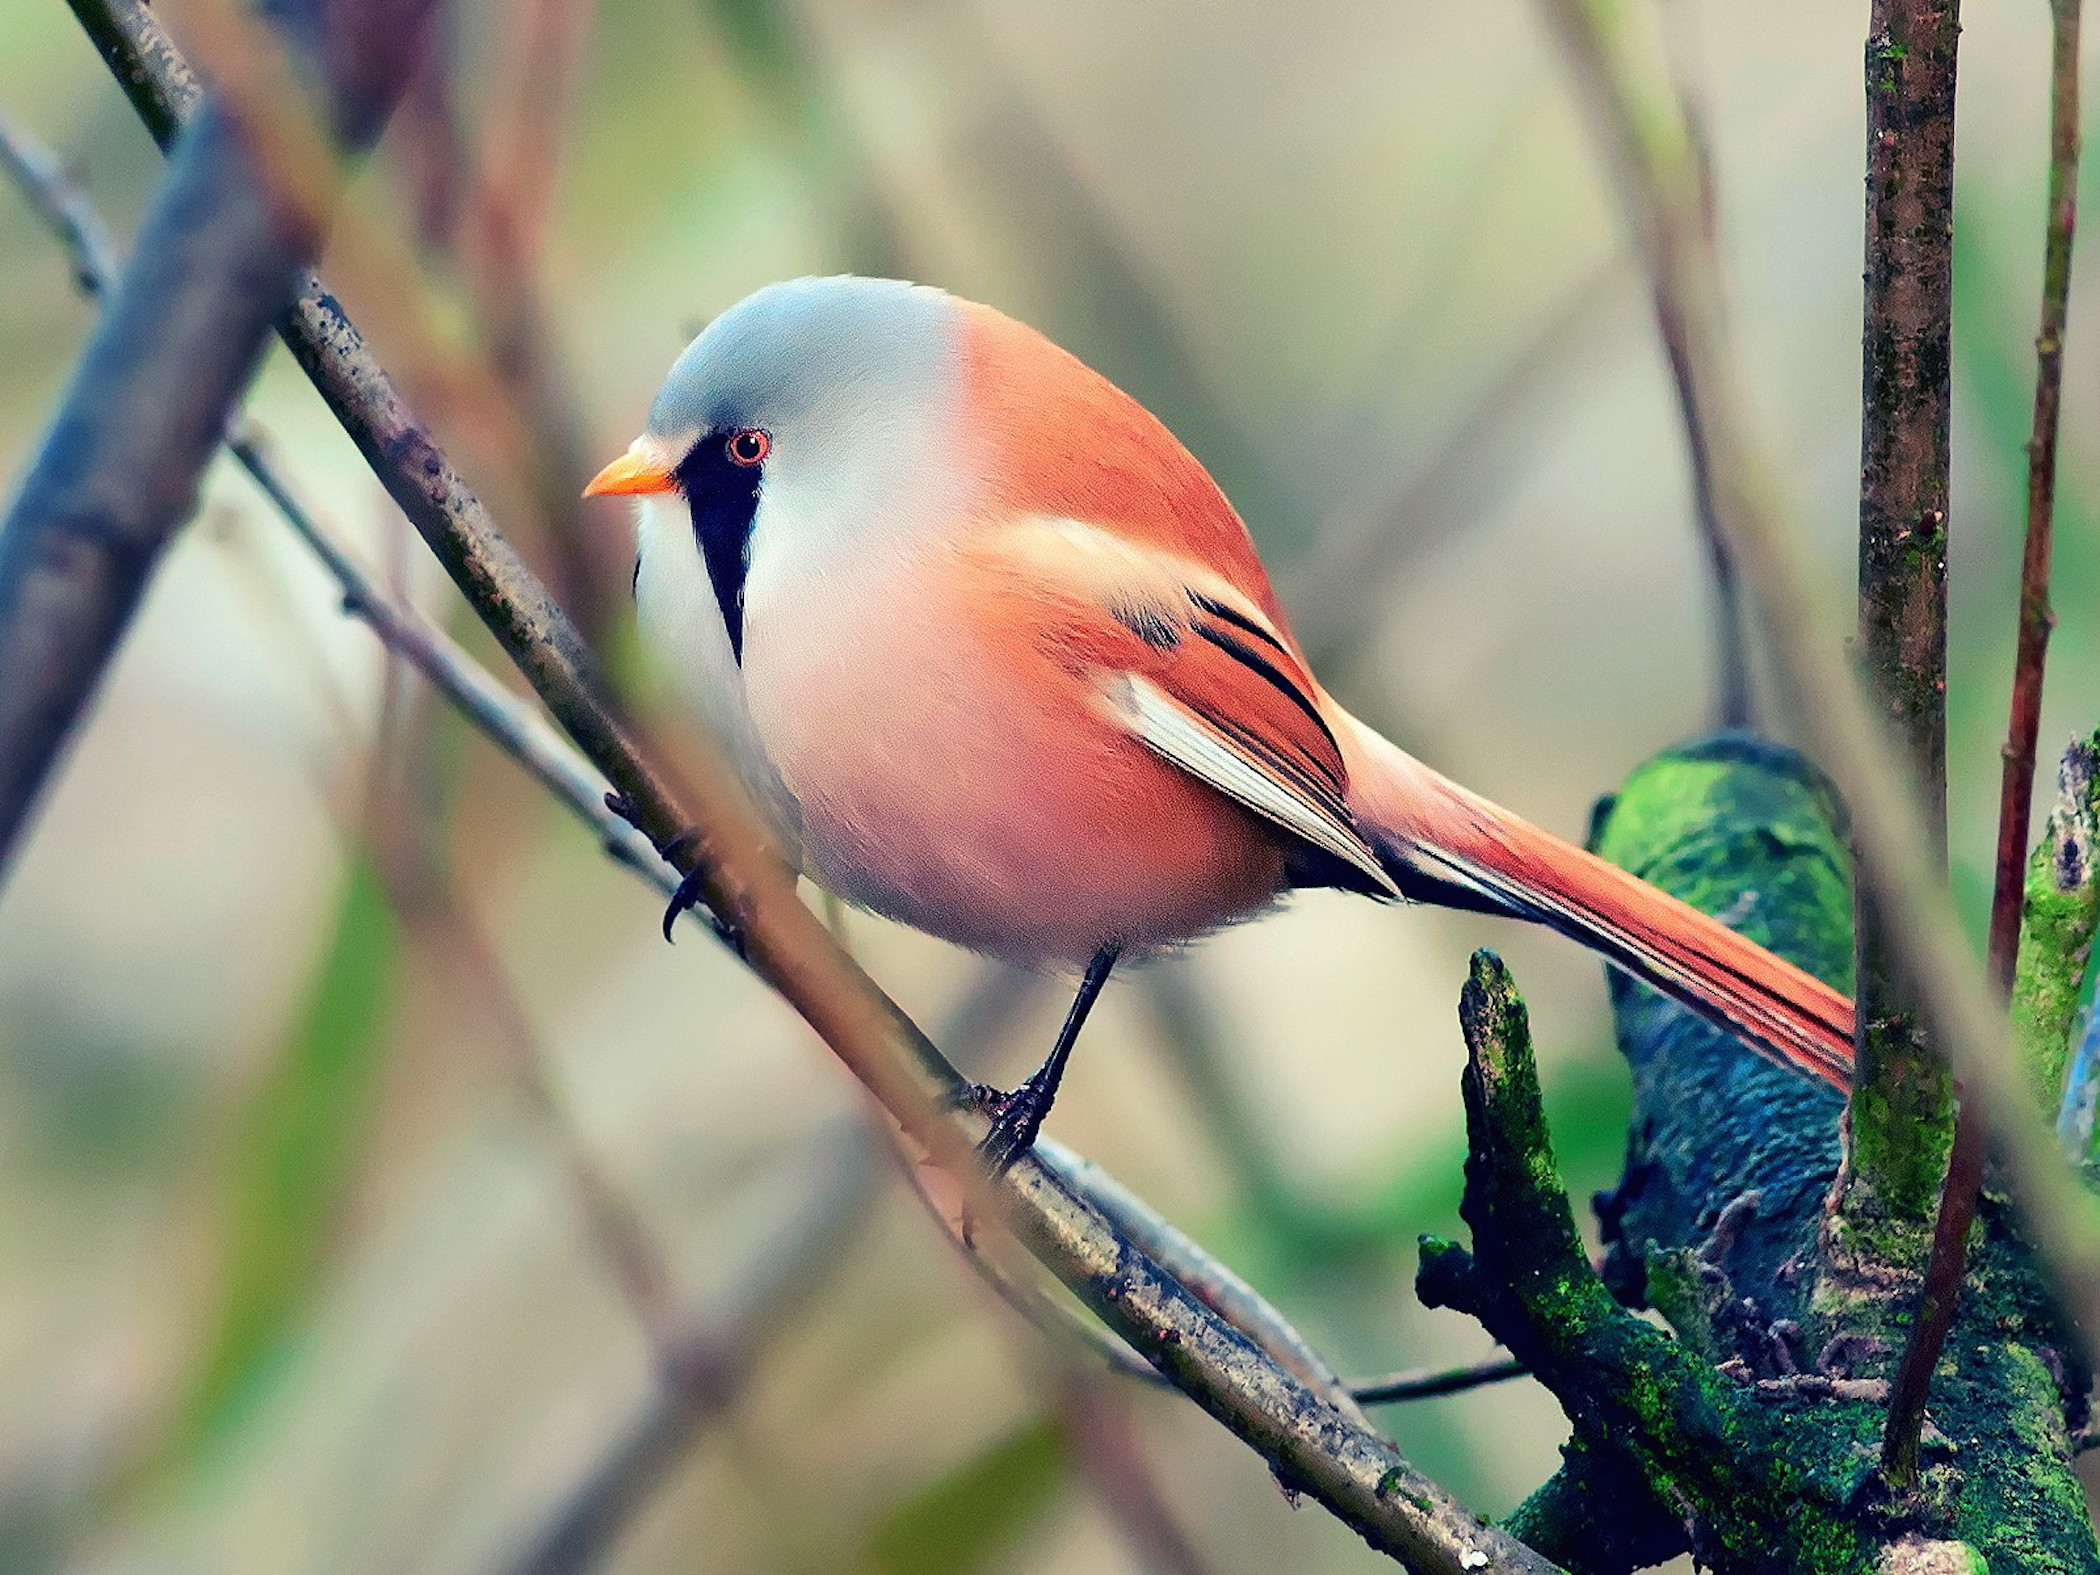

In [33]:
image

Fast.ai provides a helper function `to_thumb` to show smaller versions of the image

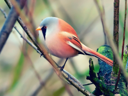

In [34]:
image.to_thumb(128)

### Uploading images to a notebook
You can upload images to a notebook by using a cell with the following content:

In [35]:
import ipywidgets as widgets

uploader = widgets.FileUpload()
uploader

FileUpload(value=(), description='Upload')

In [36]:
if uploader.value:
    display(uploader.value)
    img = PILImage.create(uploader.value[0]['content'].tobytes())
    display(img.to_thumb(256))

### Downloading Images
The fastai `vision.utils` library comes with helper functions to download images from the internet. We can use the [`download_images`](https://docs.fast.ai/vision.utils.html#download_images) function to download a list of images. Then, [`verify_images`](https://docs.fast.ai/vision.utils.html#verify_images) can be used to find and remove the images that are broken.

In [37]:
from duckduckgo_search import DDGS
from fastcore.foundation import L

def search_images(keywords: str, max_n_images: int = 100) -> list:
    """Search for images using DuckDuckGo."""
    data = []
    for r in DDGS().images(keywords):
        if len(data) >= max_n_images:
            break
        data.append(r)
    return L(data).itemgot('image')

`search_images` above also makes use of the `L` helpers. This class allows you to wrap a list and get more functional operators on it. `L(data).itemgot('image')` is going through `data`, which is a list of dicts, where each dict has a key `image`, and returning a new list with the value of `image` for each item.

In [38]:
images = search_images("bird", max_n_images=5)

In [39]:
from fastai.vision.utils import download_images

download_images("out/download_images_example/", urls=images)

In [40]:
from fastai.data.transforms import get_image_files
files = get_image_files("out/download_images_example/")
files

(#10) [Path('out/download_images_example/93d38f3f-9966-4f37-9417-06a392370cbd.jpg'),Path('out/download_images_example/802f01e7-1fdc-4c81-975e-83c74d59e6b6.jpg'),Path('out/download_images_example/acc1b6b8-bd86-4598-af3c-1f9f7bb18142.jpg'),Path('out/download_images_example/289bac80-ccb7-432a-82b7-5c2cfe1e3335.jpg'),Path('out/download_images_example/77c0ba6b-2c43-4216-81af-519f39e34b60.jpg'),Path('out/download_images_example/49e1d717-ff4d-4429-a9e2-f444b956ab60.jpg'),Path('out/download_images_example/b52ed754-63a9-428b-b379-487a71479353.jpg'),Path('out/download_images_example/5644603d-2f13-4210-a61e-8a6c2d1a2b2b.jpg'),Path('out/download_images_example/4fc4e356-ffbc-44a2-a5ae-ae6d6386d0f8.jpg'),Path('out/download_images_example/642a07f3-cf6a-44d5-b58c-170c193b6fe1.jpg')]

Its possible some images are not loadable. We should remove those:

In [41]:
from fastai.vision.utils import verify_images

failed = verify_images(files)
failed

(#0) []

In [42]:
for f in failed:
    f.unlink()

We can load all the images we just downloaded:

In [43]:
loaded_images = [Image.open(f) for f in files]

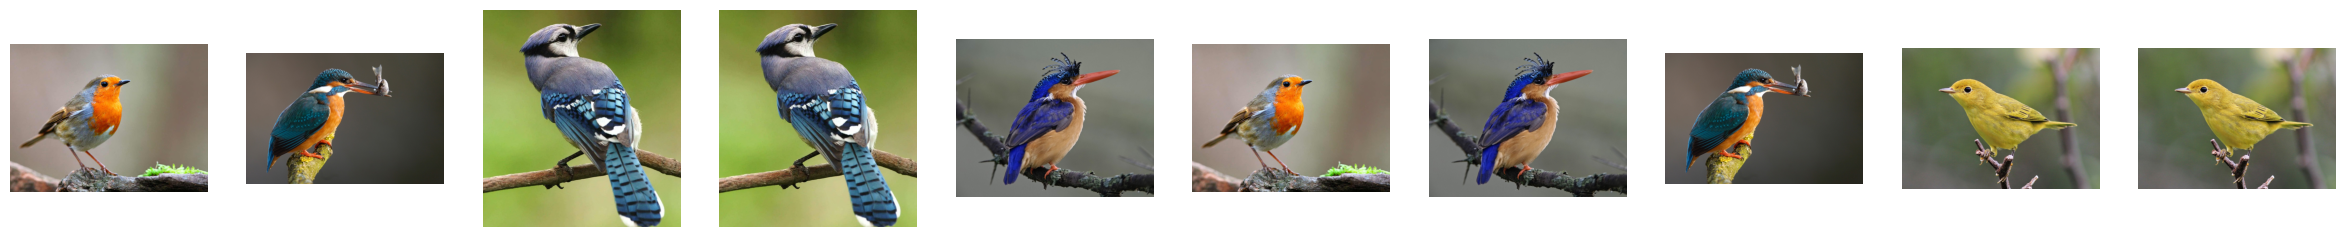

In [44]:
from fastai.torch_core import show_images
show_images(loaded_images)

### Loading external datasets
The fastai library comes with helper functions to load external datasets.

The first helper function provided is [`untar_data`](https://docs.fast.ai/data.external.html#untar_data). `untar_data` downloads and extracts the provided url. By default, this will be downloaded into `~/.fastai`

In [45]:
from fastai.data.external import *
mnist_path = untar_data(URLs.MNIST_SAMPLE)
display(mnist_path)

Path('/home/jaym/.fastai/data/mnist_sample')

In [46]:
mnist_path.ls()

(#3) [Path('/home/jaym/.fastai/data/mnist_sample/valid'),Path('/home/jaym/.fastai/data/mnist_sample/train'),Path('/home/jaym/.fastai/data/mnist_sample/labels.csv')]

In [47]:
from fastai.data.transforms import get_image_files
files = get_image_files(mnist_path, recurse=True, folders="train")
len(files)

12396

Generally, when we have a dataset like this, we will be interested in using it to train and validate models. To do this, we need to get our dataset into a `DataLoaders` object.

In the case of the MNIST dataset, the data is organized into a folder structure where the label is part of the path. For example `~/.fastai/data/mnist_sample/train/3/` will contain the training images that all should be classified as `3`. `~/.fastai/data/mnist_sample/train/7/` similarly represents images that should be classified as the number `7`.

fastai [`ImageDataLoaders`](https://docs.fast.ai/vision.data.html#imagedataloaders) can help us get a `DataLoaders` object for our dataset.

The docs for `ImageDataLoaders` shows how we can use the factory functions the load the MNIST dataset. One example is to use the `from_path_re` factory function:

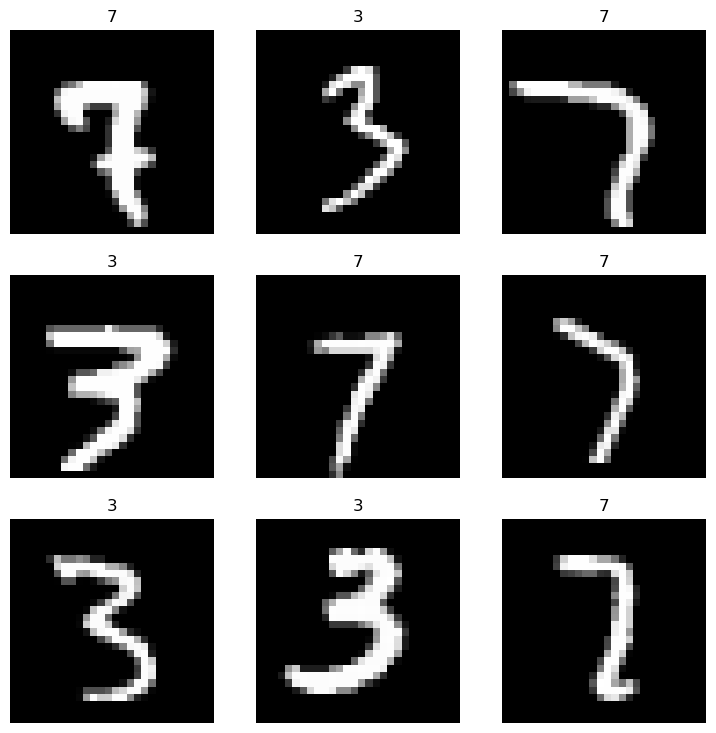

In [48]:
from fastai.vision.data import ImageDataLoaders
pat = r'/([^/]*)/\d+.png$'
dls = ImageDataLoaders.from_path_re("models", files, pat)
dls.show_batch()

## Resizing and Scaling Images

### Working with individual images
PIL provides facilities to manipulate images. Below is an example of resizing an image:

In [49]:
scale_factor = 0.5
scaled_image = image.resize((int(image.width * scale_factor), int(image.height * scale_factor)))

In [50]:
image.shape

(1575, 2100)

In [51]:
scaled_image.shape

(787, 1050)

fastai also add a `reshape` method which does the same thing:

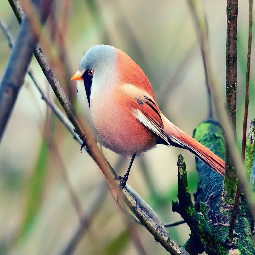

In [52]:
scaled_image.reshape(255,255)

### Working with DataLoaders
In a previous example, we loaded a dataset with dataloaders. We can provide a list of transforms to the dataloader. For example, we can ask for the images to be resized:

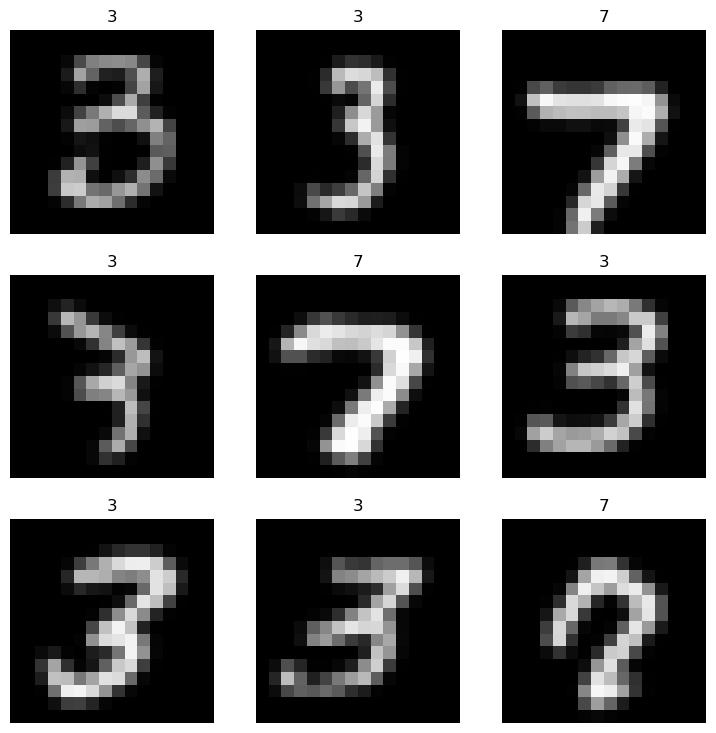

In [53]:
from fastai.vision.data import ImageDataLoaders
from fastai.vision.augment import Resize
pat = r'/([^/]*)/\d+.png$'
dls = ImageDataLoaders.from_path_re("models", files, pat, item_tfms=Resize(16))
dls.show_batch()

### Resizing images on disk
The fastai `vision.utils` library provides some helper functions for resizing images on disk. You can resize a single image with `resize_image` or a directory of images with `resize_images`:

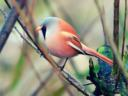

In [54]:
from fastai.vision.utils import resize_image
resize_image("images/bird.jpg", "out/resize_image_example", max_size=128)
Image.open("out/resize_image_example/images/bird.jpg")

In [55]:
from fastai.vision.utils import resize_images
from pathlib import Path
resize_images("images/", max_workers=10, recurse=True, dest="out/resize_images_example", max_size=128)
Path("out/resize_images_example/").ls()

(#2) [Path('out/resize_images_example/bird.jpg'),Path('out/resize_images_example/forest.jpg')]